In [2]:
import sys
sys.path.append("../../smsl")

In [3]:
from smsl.graphBigtraj import BigTrajGraphAgent
from smsl.config import ConfAgent
from smsl.graph import HB, ST_dsdna, RB, PR0, PR1

In [4]:
import os
import pandas as pd
import numpy as np
from IPython.display import JSON

In [5]:
class HotSpotAgent(dict, ConfAgent):
    def __init__(self, MAgent):
        ConfAgent.__init__(self)
        self.end_ns = self.time_num
        self.framesperns = self.frame_num // self.time_num
        self.MAgent = MAgent
    def load_systems(self, system2offical_name):
        ori_path = os.getcwd()
        for system, system_offical_name in system2offical_name.items():
            os.chdir(f'../../{system}/d.fluctmatch')
            b_agent = BigTrajGraphAgent(self.MAgent)
            b_agent.system_offical_name = system_offical_name
            self[system] = b_agent
        os.chdir(ori_path)
    def get_hotspot(self, verbose=0, is_return=False):
        self.m_abbr = self.get_m_abbr() 
        dict_hotspot = {self.m_abbr:{}}
        for system, b_agent in self.items():
            dict_hotspot[b_agent.m_abbr][system] = {}
            dict_hotspot[b_agent.m_abbr][system] = get_hotspot_by_graph_agent(b_agent.t_agent, verbose=verbose)
        if is_return:
            return dict_hotspot
        else:
            self.dict_hotspot = dict_hotspot
    def get_m_abbr(self):
        return list(self.values())[0].m_abbr ## first system of sub group name
    def get_df_k_with_hotspots(self, k_value='k_avg_std', is_return=False): ## for dsDNA
        global sort_system, sort_layer
        list_k_with_hotspots = []
        for s, dict_subgroup in self.dict_hotspot.items(): 
            for system, dict_system in dict_subgroup.items():
                for position, dict_position in dict_system.items():
                    pos_seq = position
                    k_avg = dict_position['hotspot']['avg']['avg']
                    k_std = dict_position['hotspot']['avg']['std']
                    list_k_with_hotspots.append({
                        # 'system'   : self[system].system_offical_name,
                        'subgroup' : self.m_abbr,
                        'sequence' : pos_seq,
                        'k_avg'    : k_avg,
                        'k_std'    : k_std,
                        'k_avg_std': f'{k_avg:.2f} ± {k_std:.2f}',
                    })
        df_k_with_hotspots_1 = pd.DataFrame(list_k_with_hotspots)
        df_k_with_hotspots = df_k_with_hotspots_1.set_index(['sequence'])
        df_k_with_hotspots = df_k_with_hotspots.pivot(columns='subgroup', values=k_value)

        ## sort the row and column index
        sort_subgroup = list(dict.fromkeys(df_k_with_hotspots_1['subgroup']))
        sort_seq      = list(dict.fromkeys(df_k_with_hotspots_1['sequence']))
        df_k_with_hotspots = df_k_with_hotspots.loc[sort_seq, sort_subgroup]
        if is_return:
            return df_k_with_hotspots
        else:
            self.df_k_with_hotspots = df_k_with_hotspots 

In [6]:
def generate_cluster_hotspots(self): ## for dsDNA
    m_abbr = self.mean.m_abbr
    if m_abbr == 'hb':
        cluster2hotspots = {
            'all': {i:['rank',i] for i in range(1, 4+1)}, ## rank1..rank4
        }
    elif m_abbr == 'st':
        cluster2hotspots = {
        'all': {i:['rank',i] for i in range(1, 6+1)}, ## rank1..rank4
        }
    elif m_abbr == 'rb':
        cluster2hotspots = {
            'T': {1:["C1'","O2"], 2:["C6","C2'"], 3:["C5","C2'"], 4:["C2","C2'"], 5:["O4'","C6"]},
            'C': {1:["C1'","O2"], 2:["C6","C2'"], 3:["C5","C2'"], 4:["C2","C2'"], 5:["O4'","C6"]},
            'A': {1:["C1'","N3"], 2:["C8","C2'"], 3:["N7","C2'"], 4:["C4","C2'"], 5:["O4'","C8"]},
            'G': {1:["C1'","N3"], 2:["C8","C2'"], 3:["N7","C2'"], 4:["C4","C2'"], 5:["O4'","C8"]},
        }
    elif m_abbr == 'pr0':
        cluster2hotspots = {
        'all': {i:['rank',i] for i in range(1, 3+1)}, ## rank1..rank4
        }
    elif m_abbr == 'pr1':
        cluster2hotspots = {
        'all': {i:['rank',i] for i in range(1, 3+1)}, ## rank1..rank4
        }
    return cluster2hotspots

## SmallTimeAgent level
def get_cluster(self, resid_i, resid_j): ## for dsDNA
    m_abbr = self.m_abbr
    if m_abbr == 'rb':
        resname_i = self.strandid2sequence['STRAND1'][resid_i]
        resname_j = self.strandid2sequence['STRAND1'][resid_j]
        if resname_i != resname_j:
            raise RuntimeError('resname_i ≠ resname_j, resid_i:', resid_i, 'resid_j:', resid_j)
        cluster = resname_i
    else:
        cluster = 'all'
    return cluster

## SmallTimeAgent level
def generate_df_position2hotspots(self, resid_i, resid_j, hotspots): ## for dsDNA
    dict_ks = {}
    df_m = self.mean.df_m
    mask1 = (df_m['Resid_i']==resid_i) & (df_m['Resid_j']==resid_j)
    df_resid_ij = df_m[mask1]
    for i, hotspot in hotspots.items():
        if isinstance(hotspot[1], int): ## rank n: ['rank', 1]
            df_sele = df_resid_ij.sort_values(by='k', ascending=False).iloc[[hotspot[1]-1]]
        elif isinstance(hotspot[1], str): ## hotspot: ['N1', 'O6']
            mask2 = (df_resid_ij['Atomname_i']==hotspot[0]) & (df_resid_ij['Atomname_j']==hotspot[1])
            df_sele = df_resid_ij[mask2]
        else:
            raise RuntimeError('Could not recognize cluster2hotspots:', cluster2hotspots)
        ## generate dict_ks
        pair_id, ser_sele = df_sele.index, df_sele.iloc[0]
        dict_ks[i] = {
            'query'     : ''.join(map(str, hotspot)),
            'atomname_i': ser_sele.Atomname_i,
            'atomname_j': ser_sele.Atomname_j,
            'k'         : {},
        }
        for time_label, st_agent in self.items():
            dict_ks[i]['k'][time_label] = st_agent.df_m.loc[pair_id].squeeze().k
        ks = pd.Series(dict_ks[i]['k'])
        dict_ks[i]['k']['avg'] = ks.mean()
        dict_ks[i]['k']['std'] = ks.std() ## Note: numpy.std(ddof=0), but pandas.std(ddof=1)
    ## k_avg in {aiaj}^s
    dict_ks['avg']  = {}
    for time_label, _ in self.items():
        ks = []
        for i, hotspot in hotspots.items():
            ks.append(dict_ks[i]['k'][time_label])
        dict_ks['avg'][time_label] = np.mean(ks)
    ks = pd.Series(dict_ks['avg'])
    dict_ks['avg']['avg'] = ks.mean()
    dict_ks['avg']['std'] = ks.std() ## Note: numpy.std(ddof=0), but pandas.std(ddof=1)
    return dict_ks

## GraphAgent level, for dsDNA
def get_hotspot_by_graph_agent(self, verbose=0):
    cluster2hotspots = generate_cluster_hotspots(self)
    dict_position = {}
    m_abbr = self.mean.m_abbr
    resid_i_max = {'hb':self.n_bp, 'st':self.n_bp-1, 'rb':self.n_bp, 'pr0':self.n_bp, 'pr1':self.n_bp-1}[m_abbr]
    for resid_i in range(1, resid_i_max+1):
        m_abbr2resid_j = {
            'hb' : self.n_bp+1-resid_i,
            'st' : resid_i+1,
            'rb' : resid_i,
            'pr0': resid_i,
            'pr1': resid_i+1,
        }
        resid_j = m_abbr2resid_j[m_abbr]
        resname_i = self.strandid2sequence['STRAND1'][resid_i]
        sequence = f'{resname_i}{resid_i}'
        ## generate dict_hotspot
        cluster = get_cluster(self.mean, resid_i, resid_j)
        hotspots = cluster2hotspots[cluster] 
        if verbose:
            print(self.system, resid_i, resid_j, cluster, hotspots)
        dict_ks = generate_df_position2hotspots(self, resid_i, resid_j, hotspots)
        dict_position[sequence] = {
            'resid_i': int(resid_i), ## save json format from int istead of np.int64(cannot save) 
            'resid_j': int(resid_j),
            'cluster': cluster,
            'hotspot': dict_ks
        }
    return dict_position

In [7]:
system2offical_name = {
'dsdna'    : 'dsDNA',
}

subgroups = [HB, ST_dsdna, RB, PR0, PR1]

In [8]:
s2hs_agent = {}
for s in subgroups:
    hs_agent = HotSpotAgent(s)
    hs_agent.load_systems(system2offical_name)
    hs_agent.get_hotspot()
    hs_agent.get_df_k_with_hotspots()
    s2hs_agent[hs_agent.m_abbr] = hs_agent

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0000_0500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0250_0750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0500_1000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0750_1250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1000_1500/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1250_1750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1500_2000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1750_2250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2000_2500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2250_2750/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2500_3000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2750_3250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3000_3500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3250_3750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3500_4000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3750_4250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4000_4500/result/pa

/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4250_4750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4500_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0000_0500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0250_0750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0500_1000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0750_1250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1000_1500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1250_1750/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1500_2000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1750_2250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2000_2500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2250_2750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2500_3000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2750_3250/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3000_3500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3250_3750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3500_4000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3750_4250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4000_4500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4250_4750/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4500_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0000_0500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0250_0750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0500_1000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0750_1250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1000_1500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1250_1750/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1500_2000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1750_2250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2000_2500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2250_2750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2500_3000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2750_3250/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3000_3500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3250_3750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3500_4000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3750_4250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4000_4500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4250_4750/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4500_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0000_0500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0250_0750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0500_1000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0750_1250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1000_1500/result/pa

/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1500_2000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1750_2250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2000_2500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2250_2750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2500_3000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2750_3250/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3000_3500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3250_3750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3500_4000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/3750_4250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4000_4500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4250_4750/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4500_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0000_0500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0250_0750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0500_1000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0750_1250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1000_1500/result/pa

/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1250_1750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1500_2000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/1750_2250/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2000_2500/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2250_2750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2500_3000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/2750_3250/result/pa

/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to 

Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4250_4750/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/4500_5000/result/pairtypes_k_b0_cutoff_5.00.csv
Reading data from: /home/user/workfolder/g4dna_protocol_demo/dsdna/d.fluctmatch/bigtraj_fluctmatch/0000_5000/result/pairtypes_k_b0_cutoff_5.00.csv


/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [8]:
## Save Json File
dict_hotspot_s = {}
for s, hs_agent in s2hs_agent.items():
    dict_hotspot_s.update(hs_agent.dict_hotspot)

import json, copy
with open(f'data/dsdna.json', 'w') as f:
        json.dump(dict_hotspot_s, f)

In [10]:
s2df_ks_position = {s:hs_agent.df_k_with_hotspots for s, hs_agent in s2hs_agent.items()}
pd.concat(list(s2df_ks_position.values()), axis=1).fillna('')

subgroup,hb,st,rb,pr0,pr1
sequence,,,,,
A1,0.07 ± 0.07,0.34 ± 0.34,8.59 ± 5.86,11.00 ± 3.36,9.52 ± 4.52
G2,5.65 ± 3.57,2.82 ± 0.28,12.67 ± 0.89,11.74 ± 1.90,5.33 ± 1.16
G3,8.17 ± 0.59,2.93 ± 0.11,11.52 ± 2.93,9.54 ± 1.49,11.09 ± 0.98
G4,10.19 ± 0.60,4.02 ± 0.09,10.44 ± 0.75,7.09 ± 1.63,10.66 ± 1.26
T5,4.70 ± 0.21,2.76 ± 0.09,15.24 ± 0.54,7.67 ± 2.92,13.59 ± 0.87
T6,2.30 ± 0.29,2.18 ± 0.09,13.34 ± 0.80,10.75 ± 1.22,3.95 ± 1.58
A7,2.80 ± 1.51,3.17 ± 0.12,11.61 ± 1.28,8.99 ± 1.95,3.75 ± 1.10
G8,9.90 ± 0.40,2.90 ± 0.09,11.03 ± 2.21,10.25 ± 2.22,6.94 ± 1.38
G9,8.71 ± 1.17,3.03 ± 0.06,9.62 ± 2.32,9.52 ± 2.39,10.47 ± 1.23


In [11]:
s2df_ks_position_avg = {s:hs_agent.get_df_k_with_hotspots(k_value='k_avg', is_return=True) for s, hs_agent in s2hs_agent.items()}
pd.concat(list(s2df_ks_position_avg.values()), axis=1).fillna('').to_csv('data/dsdna_avg.csv')

In [12]:
s2df_ks_position_std = {s:hs_agent.get_df_k_with_hotspots(k_value='k_std', is_return=True) for s, hs_agent in s2hs_agent.items()}
pd.concat(list(s2df_ks_position_std.values()), axis=1).fillna('').to_csv('data/dsdna_std.csv')

### V.S. Plot

In [13]:
from smsl.plotAgent import PlotAgent, palette
from smsl.plotAgent import font_label, font_xylabel, font_xyticks

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import json
from IPython.display import JSON

In [15]:
## declare subgroups
s2index_col = {
'hb' : 0,
'st' : 0,
'rb' : 0,
'pr0': 0,
'pr1': 0,
}
subgroups = list(s2index_col.keys())

In [21]:
plt.rcParams['svg.fonttype'] = 'none' ## set the text in svg file as <text> instead of <path>

def vsplot(system2offical_name, is_error_bar=True):
    capsize, elinewidth = (3, None) if is_error_bar else (0, 0)
    fig = plt.figure(figsize=[8.0, 9.5], dpi=100)
    gs = GridSpec(34, 18, figure=fig)

    # Create subplots
    ax_hb  = fig.add_subplot(gs[ 0: 6, 1:18])
    ax_st  = fig.add_subplot(gs[ 7:13, 1:18])
    ax_rb  = fig.add_subplot(gs[14:20, 1:18])
    ax_pr0 = fig.add_subplot(gs[21:27, 1:18])
    ax_pr1 = fig.add_subplot(gs[28:34, 1:18])

    # Plotting for ax_hb, ax_st, ax_rb, ax_pr0, and ax_pr1
    for s, ax in zip(subgroups, [ax_hb, ax_st, ax_rb, ax_pr0, ax_pr1]):
        for shift, (system, system_offical_name) in enumerate(system2offical_name.items()):
            df_loc_avg = s2df_ks_position_avg[s][s]
            df_loc_std = s2df_ks_position_std[s][s]
            k_flatten_avg = df_loc_avg.to_numpy().flatten()
            k_flatten_std = df_loc_std.to_numpy().flatten()
            ax.errorbar(np.arange(len(k_flatten_avg)), k_flatten_avg, yerr=k_flatten_std, fmt='o-', markersize=4, capsize=capsize, elinewidth=elinewidth, label=system)
        ax.set_xticks(range(len(k_flatten_avg)), df_loc_avg.keys(), rotation=0)
        ax.set_xticklabels(df_loc_avg.keys(), fontdict=font_xyticks)
        ax.set_ylabel(r'$k^{\rm{'+s+'}}$', fontdict=font_label, labelpad=0)
        ax.set_xlim(-0.8, len(k_flatten_avg)-0.2)
        ylim_max = (s2df_ks_position_avg[s]+s2df_ks_position_std[s]).loc[:].to_numpy().flatten().max() * 1.1
        ax.set_ylim(-0.5, ylim_max)

    # Add legend
    ax_hb.legend(loc='upper right', bbox_to_anchor=(1.02, 1.33), ncol=len(system2offical_name), frameon=False, prop=font_label)
    fig.subplots_adjust(hspace=1.0)
    fig.text(0.74, 0.927, r'k in kcal mol$^{-1}$ $\rm{\AA}^{-2}$')
    plt.show()
    return fig

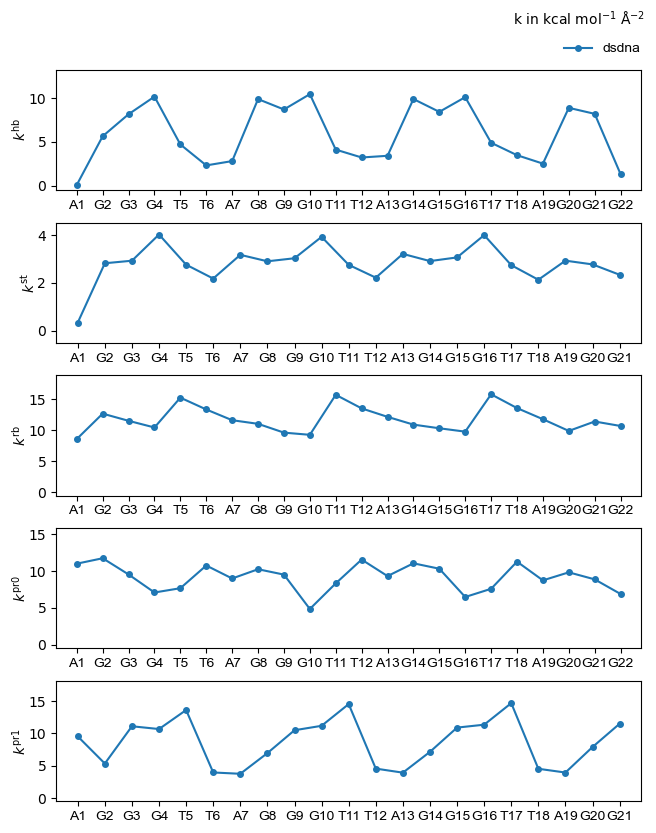

In [22]:
fig = vsplot(system2offical_name, is_error_bar=False)
fig.savefig('pic/ks_dsdna.svg', transparent=True)